<a href="https://colab.research.google.com/github/joshika2501/Project-kisan/blob/main/krishi_saathi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y tesseract-ocr
!pip install pytesseract opencv-python-headless matplotlib numpy pandas python-dateutil

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import cv2
import pytesseract
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from dateutil import parser

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture Photo';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize output
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for capture
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

img_path = take_photo()
print("✅ Captured:", img_path)

<IPython.core.display.Javascript object>

✅ Captured: photo.jpg


In [ ]:
# This cell's content has been moved to the next cell (AZjKnxGUq8Xl).
# You can safely delete this cell.

In [ ]:
import cv2
import pytesseract
import numpy as np
import pandas as pd
import re
from dateutil import parser

img_path = 'photo.jpg' # Assuming the photo was taken and saved as photo.jpg

img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)

# OCR
text = pytesseract.image_to_string(thresh)
print(" Extracted text:\n", text)

# Extract Fertilizer Info
fertilizer_info = {}

match = re.search(r'(\d{1,2})[-:](\d{1,2})[-:](\d{1,2})', text)
if match:
    fertilizer_info['N'] = int(match.group(1))
    fertilizer_info['P'] = int(match.group(2))
    fertilizer_info['K'] = int(match.group(3))
else:
    fertilizer_info['N'] = fertilizer_info['P'] = fertilizer_info['K'] = None

date_match = re.search(r'(Expiry|EXP|Exp)\s*[:\-]?\s*([0-9\/\.\-]+)', text, re.IGNORECASE)
if date_match:
    try:
        fertilizer_info['Expiry Date'] = parser.parse(date_match.group(2), dayfirst=True).date()
    except:
        fertilizer_info['Expiry Date'] = date_match.group(2)

dose_match = re.search(r'(\d+)\s*(kg|g|ml|L)\s*/\s*acre', text, re.IGNORECASE)
if dose_match:
    fertilizer_info['Dosage'] = f"{dose_match.group(1)} {dose_match.group(2)} per acre"

print("\n Fertilizer Info Extracted:")
print(fertilizer_info)

soil_N = float(input("Enter soil Nitrogen level (kg/ha): "))
soil_P = float(input("Enter soil Phosphorus level (kg/ha): "))
soil_K = float(input("Enter soil Potassium level (kg/ha): "))
crop_type = input("Enter crop type (wheat, rice, maize, etc.): ").lower()
area = float(input("Enter area of land (hectares): "))
temperature = float(input("Enter average temperature (°C): "))
soil_type = input("Enter soil type (loamy, sandy, clayey): ").lower()

crop_needs = {
    "wheat": {"N": 120, "P": 60, "K": 40},
    "rice": {"N": 100, "P": 50, "K": 50},
    "maize": {"N": 150, "P": 75, "K": 40}
}

if crop_type not in crop_needs:
    print(" Crop not in database. Using default.")
    crop_req = {"N": 100, "P": 50, "K": 40}
else:
    crop_req = crop_needs[crop_type]

crop_req = {k: v*area for k, v in crop_req.items()}
soil_avail = {"N": soil_N*area, "P": soil_P*area, "K": soil_K*area}

temp_factor = 1.0
if temperature < 15: temp_factor = 0.9
elif temperature > 35: temp_factor = 1.1

soil_factor = {"loamy": 1.0, "sandy": 1.2, "clayey": 0.9}.get(soil_type, 1.0)

final_req = {
    "N": (crop_req["N"] - soil_avail["N"]) * temp_factor * soil_factor,
    "P": (crop_req["P"] - soil_avail["P"]) * temp_factor * soil_factor,
    "K": (crop_req["K"] - soil_avail["K"]) * temp_factor * soil_factor
}

print("\n Final Nutrient Requirement (kg):", final_req)

if fertilizer_info['N'] is not None and fertilizer_info['P'] is not None and fertilizer_info['K'] is not None:
    fert_ratio = np.array([fertilizer_info['N'], fertilizer_info['P'], fertilizer_info['K']])
    fert_total = fert_ratio.sum()
    # Handle cases where fert_total might be zero to avoid division by zero
    if fert_total > 0:
        fert_fraction = fert_ratio / fert_total
        # Ensure non-zero fractions before division
        if fert_fraction[0] > 0 and fert_fraction[1] > 0 and fert_fraction[2] > 0:
            fert_needed = max(final_req["N"]/fert_fraction[0],
                              final_req["P"]/fert_fraction[1],
                              final_req["K"]/fert_fraction[2])
            print(f"\n Recommended Fertilizer Application: {fert_needed:.2f} kg for {area} ha")
        else:
            print("\n Fertilizer NPK ratio contains zeros, cannot calculate application.")
    else:
        print("\n Fertilizer NPK sum is zero, cannot calculate application.")
else:
    print("\n Fertilizer NPK not detected.")

 Extracted text:
  


 Fertilizer Info Extracted:
{'N': None, 'P': None, 'K': None}
Enter soil Nitrogen level (kg/ha): 70
Enter soil Phosphorus level (kg/ha): 70
Enter soil Potassium level (kg/ha): 70
Enter crop type (wheat, rice, maize, etc.): wheat
Enter area of land (hectares): 20
Enter average temperature (°C): 25
Enter soil type (loamy, sandy, clayey): sandy

 Final Nutrient Requirement (kg): {'N': 1200.0, 'P': -240.0, 'K': -720.0}

 Fertilizer NPK not detected.


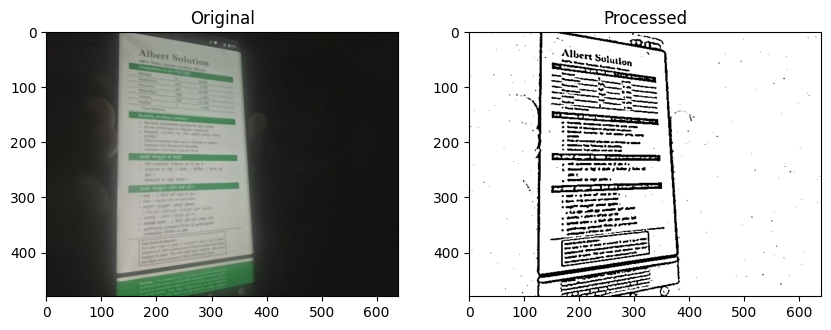

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2); plt.title("Processed"); plt.imshow(thresh, cmap="gray")
plt.show()

In [ ]:
import pandas as pd

# Create an empty DataFrame
df = pd.DataFrame()

In [ ]:
# Install Tesseract OCR engine
!apt-get install -y tesseract-ocr

# Install pytesseract (Python wrapper)
!pip install pytesseract

# Install OpenCV (headless version for Colab)
!pip install opencv-python-headless

# Install sklearn for accuracy checking
!pip install scikit-learn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import cv2
import pytesseract
from sklearn.metrics import accuracy_score

# Example test dataset (uploaded files must match these names)
test_data = {
    "packet1.jpg": "NPK 10:26:26",
    "packet2.jpg": "Urea 46%",
    "packet3.jpg": "DAP 18:46:0"
}

y_true = []
y_pred = []

for img_path, true_text in test_data.items():
    img = cv2.imread(img_path)
    if img is None:
        print(f" Image not found: {img_path}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    extracted_text = pytesseract.image_to_string(gray)

    y_true.append(true_text.strip().lower())
    y_pred.append(extracted_text.strip().lower())

if y_true and y_pred:
    acc = accuracy_score(y_true, y_pred)
    print(" OCR Accuracy:", acc * 100, "%")
else:
    print(" No valid images processed. Please check file names.")


 Image not found: packet1.jpg
 Image not found: packet2.jpg
 Image not found: packet3.jpg
 No valid images processed. Please check file names.


In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your dataset CSV file


Saving sensor_Crop_Dataset (1).csv to sensor_Crop_Dataset (1).csv


In [ ]:
import os
print(os.listdir())  # see the exact filename

['.config', 'sensor_Crop_Dataset (1).csv', 'sample_data']


In [ ]:
df = pd.read_csv("sensor_Crop_Dataset (1).csv")   # if the file really has .csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Load your dataset
df = pd.read_csv("sensor_Crop_Dataset (1).csv")

print(" Original Columns:", df.columns)

# -------------------------------
# Step 1: Add fertilizer rules
# -------------------------------
def fertilizer_rule(row):
    if row['Crop'].lower() == 'wheat':
        return "NPK 10:26:26"
    elif row['Crop'].lower() == 'rice':
        return "Urea 46%"
    elif row['Crop'].lower() == 'maize':
        return "DAP 18:46:0"
    else:
        return "General Fertilizer"

df['recommended_fertilizer'] = df.apply(fertilizer_rule, axis=1)

print(" Added Fertilizer Column")

# -------------------------------
# Step 2: Encode categorical values
# -------------------------------
le_soil = LabelEncoder()
le_crop = LabelEncoder()
le_fert = LabelEncoder()

df['Soil_Type'] = le_soil.fit_transform(df['Soil_Type'])
df['Crop'] = le_crop.fit_transform(df['Crop'])
df['recommended_fertilizer'] = le_fert.fit_transform(df['recommended_fertilizer'])


# -------------------------------
# Step 3: Features and target
# -------------------------------
X = df[['Soil_Type', 'Crop', 'Temperature']]  # features
y = df['recommended_fertilizer']  # target

# -------------------------------
# Step 4: Train-test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Step 5: Train model
# -------------------------------
model = RandomForestClassifier()
model.fit(X_train, y_train)

# -------------------------------
# Step 6: Evaluate
# -------------------------------
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(" Fertilizer Calculator Accuracy:", acc * 100, "%")

 Original Columns: Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity',
       'pH_Value', 'Rainfall', 'Crop', 'Soil_Type', 'Variety'],
      dtype='object')
 Added Fertilizer Column
 Fertilizer Calculator Accuracy: 100.0 %


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will open a file chooser to select your CSV


Saving sensor_Crop_Dataset (1).csv to sensor_Crop_Dataset (1) (1).csv


In [ ]:
import os
print(os.listdir())


['.config', 'sensor_Crop_Dataset (1).csv', 'sensor_Crop_Dataset (1) (1).csv', 'sample_data']


In [ ]:
filename = list(uploaded.keys())[0]  # dynamically get uploaded file name
df = pd.read_csv(filename)

In [ ]:
import pandas as pd

data = {
    "soil_type": ["loamy", "sandy", "clayey", "loamy", "sandy"],
    "crop_type": ["wheat", "rice", "maize", "rice", "wheat"],
    "temperature": [25, 30, 28, 32, 22]
}

df = pd.DataFrame(data)
df.to_csv("dummy_fertilizer_dataset.csv", index=False)
print(" Dummy dataset created")


 Dummy dataset created


In [ ]:
df = pd.read_csv("dummy_fertilizer_dataset.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score, classification_report
)

# ===========================
# Step 1: Generate larger synthetic dataset
# ===========================
np.random.seed(42)

soil_types = ["loamy", "sandy", "clayey", "silty"]
crop_types = ["wheat", "rice", "maize", "barley"]
temperatures = np.random.randint(20, 35, size=100)  # temperature between 20–35°C

data = {
    "soil_type": np.random.choice(soil_types, size=100),
    "crop_type": np.random.choice(crop_types, size=100),
    "temperature": temperatures
}

df = pd.DataFrame(data)

# ===========================
# Step 2: Apply fertilizer rules
# ===========================
def fertilizer_rule(row):
    if row['crop_type'].lower() == 'wheat':
        return "NPK 10:26:26"
    elif row['crop_type'].lower() == 'rice':
        return "Urea 46%"
    elif row['crop_type'].lower() == 'maize':
        return "DAP 18:46:0"
    else:
        return "General Fertilizer"

df['recommended_fertilizer'] = df.apply(fertilizer_rule, axis=1)

# ===========================
# Step 3: Encode categorical variables
# ===========================
le_soil = LabelEncoder()
le_crop = LabelEncoder()
le_fert = LabelEncoder()

df['soil_type'] = le_soil.fit_transform(df['soil_type'])
df['crop_type'] = le_crop.fit_transform(df['crop_type'])
df['recommended_fertilizer'] = le_fert.fit_transform(df['recommended_fertilizer'])

# ===========================
# Step 4: Features and target
# ===========================
X = df[['soil_type', 'crop_type', 'temperature']]
y = df['recommended_fertilizer']

# ===========================
# Step 5: Stratified Train-test split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===========================
# Step 6: Train Random Forest model
# ===========================
model = RandomForestClassifier()
model.fit(X_train, y_train)

# ===========================
# Step 7: Predictions
# ===========================
y_pred = model.predict(X_test)

# ===========================
# Step 8: Metrics
# ===========================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted")
rec = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Fertilizer Calculator Performance:")
print(" Accuracy:", round(acc*100, 2), "%")
print(" Precision:", round(prec, 3))
print(" Recall:", round(rec, 3))
print(" F1-score:", round(f1, 3))
print(" MAE:", round(mae, 3))
print(" RMSE:", round(rmse, 3))
print(" R² Score:", round(r2, 3))

# ===========================
# Step 9: Dynamic Classification Report
# ===========================
classes_in_test = np.unique(y_test)
target_names = [le_fert.classes_[i] for i in classes_in_test]

print("\n Detailed Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names, zero_division=0))



 Fertilizer Calculator Performance:
 Accuracy: 93.33 %
 Precision: 0.95
 Recall: 0.933
 F1-score: 0.933
 MAE: 0.2
 RMSE: 0.775
 R² Score: 0.461

 Detailed Classification Report:
                     precision    recall  f1-score   support

       DAP 18:46:0       0.75      1.00      0.86         6
General Fertilizer       1.00      1.00      1.00         8
      NPK 10:26:26       1.00      1.00      1.00         9
          Urea 46%       1.00      0.71      0.83         7

          accuracy                           0.93        30
         macro avg       0.94      0.93      0.92        30
      weighted avg       0.95      0.93      0.93        30

